**Практическое задание №5 по курсу "Методы и технологии машинного обучения"**

*Арешин Станислав Олегович М8О-111М-21*

**Задание**

* Выбрать датасет, алгоритм классификации и построить модель с подбором оптимальных параметров.  

* При помощи методов feature engineering и feature selection попытаться улучшить метрики качества.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Baseline

## Загрузка данных

https://www.kaggle.com/sagnik1511/car-insurance-data


Компания поделилась своими ежегодными данными по автострахованию. Предстоит выяснить реальное поведение клиентов на основе этих данных.

In [2]:
pd.options.display.max_columns = 20

In [3]:
df = pd.read_csv('Car_Insurance_Claim.csv').drop(['ID'], axis=1)
print(df.shape)
df.head()

(10000, 18)


,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null  

In [5]:
df['OUTCOME'] = df['OUTCOME'].astype('int64')

## Train-test split

Разобьем данные на обучение и тест в соотношении 0.8:0.2.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['OUTCOME'])

print(f'Train shape : {df_train.shape}')
print(f'Test shape : {df_test.shape}')

Train shape : (8000, 18)
Test shape : (2000, 18)


## Выделение целевой величины

In [7]:
y_train_series = df_train['OUTCOME']
df_train.drop(['OUTCOME'], axis=1, inplace=True)

y_test_series = df_test['OUTCOME']
df_test.drop(['OUTCOME'], axis=1, inplace=True)

## Обработка пропущенных значений

Отобразим график пропущенных значений датасета.

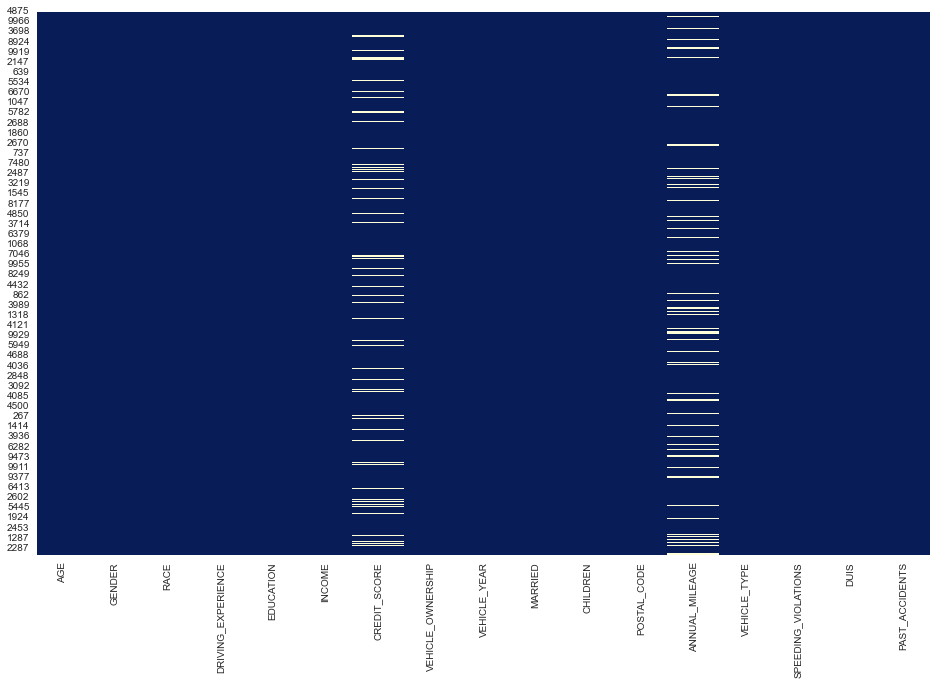

In [8]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

На графике видно, что в признаках 'CREDIT_SCORE', 'ANNUAL_MILEAGE' содержатся пропущенные значения. Их надо обработать. Посмотрим на описательные статистики этих  признаков.

In [9]:
df_train[['CREDIT_SCORE', 'ANNUAL_MILEAGE']].describe()

,CREDIT_SCORE,ANNUAL_MILEAGE
count,7197.000000,7241.000000
mean,0.514950,11715.923215
std,0.137107,2828.394261
min,0.053358,2000.000000
25%,0.416935,10000.000000
50%,0.524191,12000.000000
75%,0.617009,14000.000000
max,0.915883,22000.000000


Исходя из процентилей, мне кажется, логичным будет заменить пропущенные значения в каждом признаке на медианное значение, так как медиана более устойчива к выброса. Сделаем это с помощью SimpleImputer.

In [10]:
from sklearn.impute import SimpleImputer

cols_to_fill = ['CREDIT_SCORE', 'ANNUAL_MILEAGE']
to_fill_train = np.array(df_train[cols_to_fill])

imp = SimpleImputer(strategy='median')

fill_result_train = imp.fit_transform(to_fill_train)

imp.statistics_

array([5.24190617e-01, 1.20000000e+04])

In [11]:
df_train[cols_to_fill] = fill_result_train
df_train.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
4875,26-39,female,minority,10-19y,university,upper class,0.712351,0.0,after 2015,0.0,0.0,10238,16000.0,sedan,0,0,0
2191,65+,female,majority,0-9y,university,upper class,0.533479,1.0,before 2015,1.0,1.0,10238,8000.0,sedan,0,0,0
2271,40-64,female,minority,10-19y,university,upper class,0.694596,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0
7184,26-39,female,majority,10-19y,university,upper class,0.515658,0.0,before 2015,0.0,1.0,10238,15000.0,sedan,0,0,1
3910,40-64,female,majority,20-29y,high school,upper class,0.537726,0.0,before 2015,1.0,1.0,32765,6000.0,sedan,3,2,1


Снова построим график выбросов в датасете.

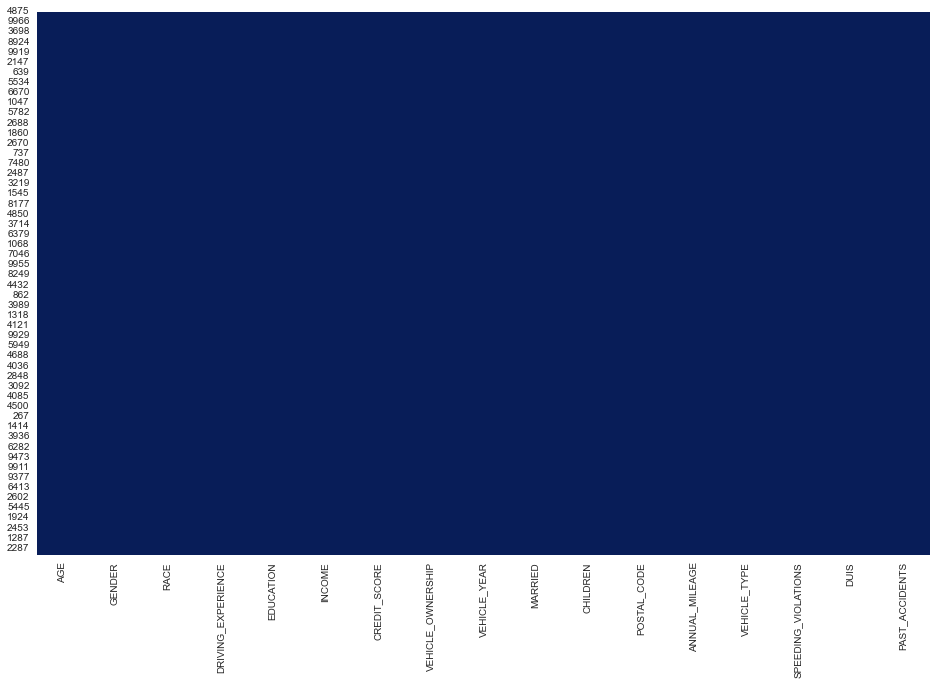

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Видно, что все выбросы почистили. Повторим те же действия для тестовой выборки, используя уже обученный SimpleImputer.

In [13]:
to_fill_test = np.array(df_test[cols_to_fill])
fill_result_test = imp.transform(to_fill_test)

df_test[cols_to_fill] = fill_result_test
df_test.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
7205,26-39,male,majority,10-19y,university,middle class,0.437373,0.0,after 2015,1.0,0.0,10238,14000.0,sedan,2,0,2
3658,65+,female,majority,30y+,university,upper class,0.708114,1.0,after 2015,1.0,1.0,10238,9000.0,sedan,2,0,1
6489,26-39,female,majority,0-9y,none,poverty,0.205296,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,0,0,0
7695,16-25,male,majority,0-9y,high school,working class,0.370227,1.0,before 2015,0.0,0.0,10238,14000.0,sedan,0,0,0
389,26-39,male,majority,0-9y,high school,middle class,0.461156,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0


## Баланс целевой величины

Проверим баланс целевой величины

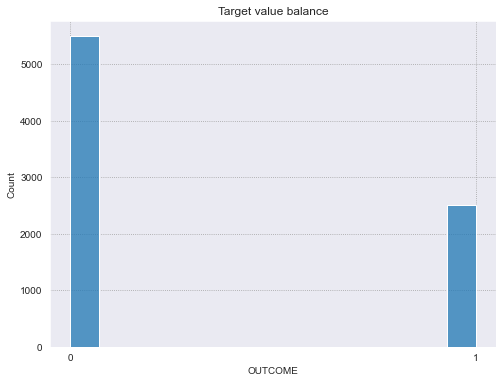

In [14]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=y_train_series)
plt.xticks((0,1))
plt.show()

Данные не сбалансированы по целевой величине. Будем оценивать качество по репрезентативной в данном случае метрике f1, а также укажем параметр class_weights = 'balanced' для алгоритма.

## OrdinalEncoder

Для кодировки категориальных признаков сначала было решено использовать OrdinalEncoder из библиотеки category_encoders без указания отношений порядка. Изначально хотел использовать LabelEncoder из sklearn, но в category_encoders удобнее интерфейс, так можно сразу применить ко всему датасету. Если не указывать отношения порядка, OrdinalEncoder эквивалентен LabelEncoder.

OrdinalEncoder кодирует значение категориального признака целым числом. Метод плох тем, что создаёт в датасете отношения порядка между значениями категориальных признаков, которых в исходном датасете могло не быть (1<2<3 и т.д). Но для бейслайна я думаю сойдёт.

Отметим, что кодировщик обучается только на обучающей выборке, для валидации используем метод transform, чтобы имитировать тест (новые данные, которых мы пока не видели)

In [15]:
cat_columns = list(df_train.select_dtypes('object').columns)
cat_columns

['AGE',
 'GENDER',
 'RACE',
 'DRIVING_EXPERIENCE',
 'EDUCATION',
 'INCOME',
 'VEHICLE_YEAR',
 'VEHICLE_TYPE']

In [16]:
from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder(cols = cat_columns)
df_train_encoded = encoder.fit_transform(df_train)
print(df_train_encoded.shape)
df_train_encoded.head()

(8000, 17)


,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
4875,1,1,1,1,1,1,0.712351,0.0,1,0.0,0.0,10238,16000.0,1,0,0,0
2191,2,1,2,2,1,1,0.533479,1.0,2,1.0,1.0,10238,8000.0,1,0,0,0
2271,3,1,1,1,1,1,0.694596,1.0,1,0.0,1.0,10238,12000.0,1,0,0,0
7184,1,1,2,1,1,1,0.515658,0.0,2,0.0,1.0,10238,15000.0,1,0,0,1
3910,3,1,2,3,2,1,0.537726,0.0,2,1.0,1.0,32765,6000.0,1,3,2,1


Повторим для обучающей выборки с уже обученным Encoder

In [17]:
df_test_encoded = encoder.transform(df_test)
print(df_test_encoded.shape)
df_test_encoded.head()

(2000, 17)


,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
7205,1,2,2,1,1,2,0.437373,0.0,1,1.0,0.0,10238,14000.0,1,2,0,2
3658,2,1,2,4,1,1,0.708114,1.0,1,1.0,1.0,10238,9000.0,1,2,0,1
6489,1,1,2,2,3,4,0.205296,1.0,2,0.0,0.0,32765,12000.0,1,0,0,0
7695,4,2,2,2,2,3,0.370227,1.0,2,0.0,0.0,10238,14000.0,1,0,0,0
389,1,2,2,2,2,2,0.461156,1.0,1,0.0,1.0,10238,12000.0,1,0,0,0


## Преобразование в np.array

Этап необязательный, но мне так удобнее работать.

In [18]:
X_train = np.array(df_train_encoded)
y_train = np.array(y_train_series)

X_test = np.array(df_test_encoded)
y_test = np.array(y_test_series)

## RandomForest Classifier

В качестве алгоритма классификации я решил выбрать ансамбль RandomForest Classifier.

### Подбор параметров

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid = [{
    'n_estimators' : [100, 200, 300],
    'min_samples_leaf' : [1, 3, 5, 7, 10],
    'max_features' : ['auto', 'sqrt', 'log2']
}]

model = RandomForestClassifier(class_weight='balanced')

gs = GridSearchCV(model, param_grid=param_grid, cv = 5, scoring='f1', verbose=3,  n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 3, 5, 7, 10],
                          'n_estimators': [100, 200, 300]}],
             scoring='f1', verbose=3)

In [21]:
gs.best_params_, gs.best_score_

({'max_features': 'auto', 'min_samples_leaf': 7, 'n_estimators': 200},
 0.7614282169869746)

### Тест

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [24]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced',
                             max_features='auto',min_samples_leaf=7)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))

0.737527114967462


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1373
           1       0.67      0.81      0.74       627

    accuracy                           0.82      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.83      0.82      0.82      2000



Получен f1_score = 0.737527114967462. Попробуем улучшить его, поработав дополнительно с данными.

# Работа с данными

Пропуски ранее уже заполнили, попробуем поменять способ кодирования категориальных признаков на OneHot Encoding, затем отберем наиболее информативные признаки, попробуем почистить выбросы и заново потюнить алгоритм, чтобы получить лучший скор.

## OneHot

Используем OneHot Encoder. В библиотеке category_encoders он мне показался удобнее, чем функция pandas.get_dummies, так как данная реализация имеет такой же интерфейс, как библиотека sklearn.

In [26]:
cat_columns = list(df_train.select_dtypes('object').columns)
cat_columns

['AGE',
 'GENDER',
 'RACE',
 'DRIVING_EXPERIENCE',
 'EDUCATION',
 'INCOME',
 'VEHICLE_YEAR',
 'VEHICLE_TYPE']

In [27]:
from category_encoders.one_hot import OneHotEncoder

encoder = OneHotEncoder(cols = cat_columns, use_cat_names=True)
df_train_encoded = encoder.fit_transform(df_train)
print(df_train_encoded.shape)
df_train_encoded.head()

(8000, 32)


,AGE_26-39,AGE_65+,AGE_40-64,AGE_16-25,GENDER_female,GENDER_male,RACE_minority,RACE_majority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_0-9y,...,VEHICLE_YEAR_before 2015,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
4875,1,0,0,0,1,0,1,0,1,0,...,0,0.0,0.0,10238,16000.0,1,0,0,0,0
2191,0,1,0,0,1,0,0,1,0,1,...,1,1.0,1.0,10238,8000.0,1,0,0,0,0
2271,0,0,1,0,1,0,1,0,1,0,...,0,0.0,1.0,10238,12000.0,1,0,0,0,0
7184,1,0,0,0,1,0,0,1,1,0,...,1,0.0,1.0,10238,15000.0,1,0,0,0,1
3910,0,0,1,0,1,0,0,1,0,0,...,1,1.0,1.0,32765,6000.0,1,0,3,2,1


Повторяем действия для тестовой выборки с обученным Encoder

In [28]:
df_test_encoded = encoder.transform(df_test)
print(df_test_encoded.shape)
df_test_encoded.head()

(2000, 32)


,AGE_26-39,AGE_65+,AGE_40-64,AGE_16-25,GENDER_female,GENDER_male,RACE_minority,RACE_majority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_0-9y,...,VEHICLE_YEAR_before 2015,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
7205,1,0,0,0,0,1,0,1,1,0,...,0,1.0,0.0,10238,14000.0,1,0,2,0,2
3658,0,1,0,0,1,0,0,1,0,0,...,0,1.0,1.0,10238,9000.0,1,0,2,0,1
6489,1,0,0,0,1,0,0,1,0,1,...,1,0.0,0.0,32765,12000.0,1,0,0,0,0
7695,0,0,0,1,0,1,0,1,0,1,...,1,0.0,0.0,10238,14000.0,1,0,0,0,0
389,1,0,0,0,0,1,0,1,0,1,...,0,0.0,1.0,10238,12000.0,1,0,0,0,0


## Отбор важных признаков

Для отбора признаков можно использовать всё тот же случайный лес, а точнее его атрибут feature_importances_. Обучим алгоритм и визуализируем полученные результаты.

In [29]:
X_train = np.array(df_train_encoded)
y_train = np.array(y_train_series)

X_test = np.array(df_test_encoded)
y_test = np.array(y_test_series)

[0.01566667 0.00744134 0.01072899 0.04639729 0.01638222 0.01684082
 0.00721368 0.00791652 0.02049281 0.10186639 0.02043366 0.00665348
 0.01276027 0.01481251 0.01126535 0.02086495 0.0114644  0.01135776
 0.0220411  0.15438599 0.07701941 0.03471539 0.03027616 0.02314237
 0.02284124 0.04995492 0.09412435 0.00593317 0.00572106 0.05920479
 0.0140022  0.04607875]


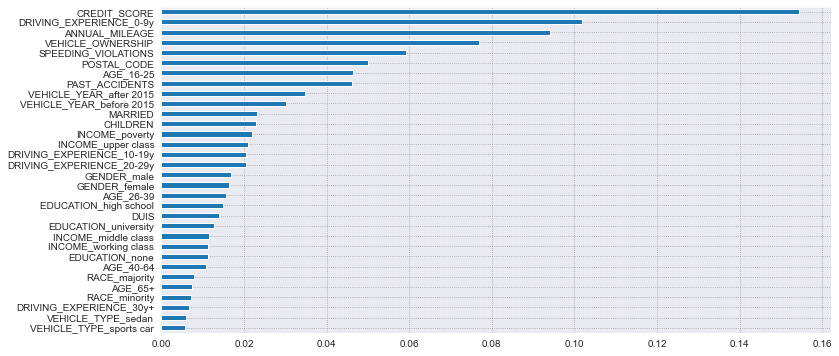

In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=df_train_encoded.columns).sort_values()
plt.figure(figsize=(12,6))
feat_importances.plot(kind='barh')
plt.show()

За счет кодирования OneHot, пространство признаков выросло до 32. Предлагаю оставить топ 17 лучших, так как не хочется терять слишком много информации. Такое значение кажется оптимальным, чтобы снизить размерность и убрать лишние сплиты у случайного леса.

In [31]:
feat_importances[::-1][:17]

CREDIT_SCORE                 0.154386
DRIVING_EXPERIENCE_0-9y      0.101866
ANNUAL_MILEAGE               0.094124
VEHICLE_OWNERSHIP            0.077019
SPEEDING_VIOLATIONS          0.059205
POSTAL_CODE                  0.049955
AGE_16-25                    0.046397
PAST_ACCIDENTS               0.046079
VEHICLE_YEAR_after 2015      0.034715
VEHICLE_YEAR_before 2015     0.030276
MARRIED                      0.023142
CHILDREN                     0.022841
INCOME_poverty               0.022041
INCOME_upper class           0.020865
DRIVING_EXPERIENCE_10-19y    0.020493
DRIVING_EXPERIENCE_20-29y    0.020434
GENDER_male                  0.016841
dtype: float64

In [32]:
best_features = feat_importances[::-1][:17].index.to_list()
best_features

['CREDIT_SCORE',
 'DRIVING_EXPERIENCE_0-9y',
 'ANNUAL_MILEAGE',
 'VEHICLE_OWNERSHIP',
 'SPEEDING_VIOLATIONS',
 'POSTAL_CODE',
 'AGE_16-25',
 'PAST_ACCIDENTS',
 'VEHICLE_YEAR_after 2015',
 'VEHICLE_YEAR_before 2015',
 'MARRIED',
 'CHILDREN',
 'INCOME_poverty',
 'INCOME_upper class',
 'DRIVING_EXPERIENCE_10-19y',
 'DRIVING_EXPERIENCE_20-29y',
 'GENDER_male']

In [33]:
df_train_encoded = df_train_encoded[best_features]
df_train_encoded.head()

,CREDIT_SCORE,DRIVING_EXPERIENCE_0-9y,ANNUAL_MILEAGE,VEHICLE_OWNERSHIP,SPEEDING_VIOLATIONS,POSTAL_CODE,AGE_16-25,PAST_ACCIDENTS,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,MARRIED,CHILDREN,INCOME_poverty,INCOME_upper class,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,GENDER_male
4875,0.712351,0,16000.0,0.0,0,10238,0,0,1,0,0.0,0.0,0,1,1,0,0
2191,0.533479,1,8000.0,1.0,0,10238,0,0,0,1,1.0,1.0,0,1,0,0,0
2271,0.694596,0,12000.0,1.0,0,10238,0,0,1,0,0.0,1.0,0,1,1,0,0
7184,0.515658,0,15000.0,0.0,0,10238,0,1,0,1,0.0,1.0,0,1,1,0,0
3910,0.537726,0,6000.0,0.0,3,32765,0,1,0,1,1.0,1.0,0,1,0,1,0


In [34]:
df_test_encoded = df_test_encoded[best_features]
df_test_encoded.head()

,CREDIT_SCORE,DRIVING_EXPERIENCE_0-9y,ANNUAL_MILEAGE,VEHICLE_OWNERSHIP,SPEEDING_VIOLATIONS,POSTAL_CODE,AGE_16-25,PAST_ACCIDENTS,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,MARRIED,CHILDREN,INCOME_poverty,INCOME_upper class,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,GENDER_male
7205,0.437373,0,14000.0,0.0,2,10238,0,2,1,0,1.0,0.0,0,0,1,0,1
3658,0.708114,0,9000.0,1.0,2,10238,0,1,1,0,1.0,1.0,0,1,0,0,0
6489,0.205296,1,12000.0,1.0,0,32765,0,0,0,1,0.0,0.0,1,0,0,0,0
7695,0.370227,1,14000.0,1.0,0,10238,1,0,0,1,0.0,0.0,0,0,0,0,1
389,0.461156,1,12000.0,1.0,0,10238,0,0,1,0,0.0,1.0,0,0,0,0,1


## Очитска от выбросов

Проверим наличие выбросов в датасете по чиловым признакам

In [35]:
df_train_encoded[['CREDIT_SCORE', 'ANNUAL_MILEAGE']].describe()

,CREDIT_SCORE,ANNUAL_MILEAGE
count,8000.000000,8000.00000
mean,0.515878,11742.87500
std,0.130073,2692.14927
min,0.053358,2000.00000
25%,0.430899,10000.00000
50%,0.524191,12000.00000
75%,0.606143,13000.00000
max,0.915883,22000.00000


По описательным статистикам видно большое различие между минимальным и максимальным значениями в обоих признаках. Подозреваю, что в них есть выбросы. Построим boxplot по этим признакам.

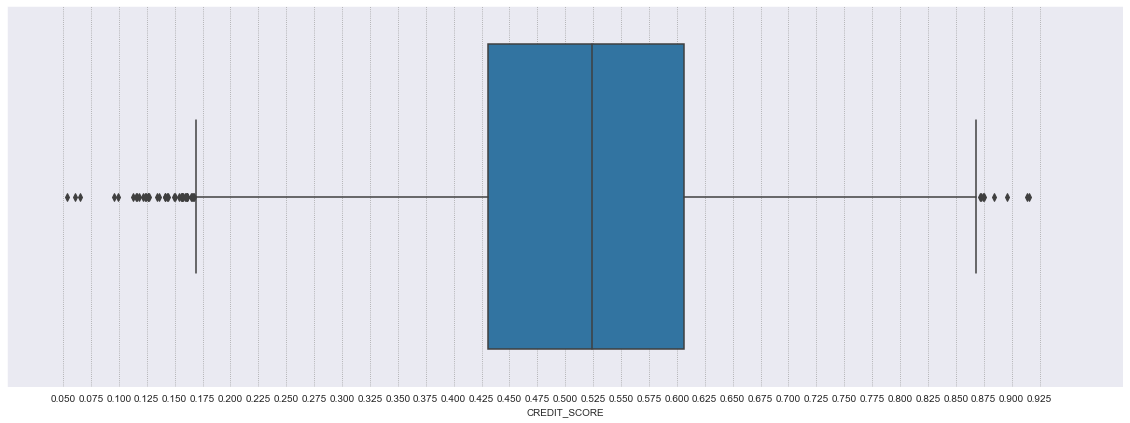

In [36]:
plt.figure(figsize=(20,7))
sns.boxplot(x = df_train_encoded['CREDIT_SCORE'])
plt.xlim(0, 1)
plt.xticks(np.arange(0.05, 0.95, 0.025))
plt.show()

Видно, что в признаке CREDIT_SCORE есть выбросы, очистим значения меньше 0.17 и больше 0.87 в обучающей выборке:

In [37]:
df_train_encoded = df_train_encoded[df_train_encoded['CREDIT_SCORE'] >= 0.17]
df_train_encoded = df_train_encoded[df_train_encoded['CREDIT_SCORE'] <= 0.87]
len(df_train_encoded)

7950

In [38]:
y_train_series = y_train_series[df_train_encoded.index]
len(y_train_series)

7950

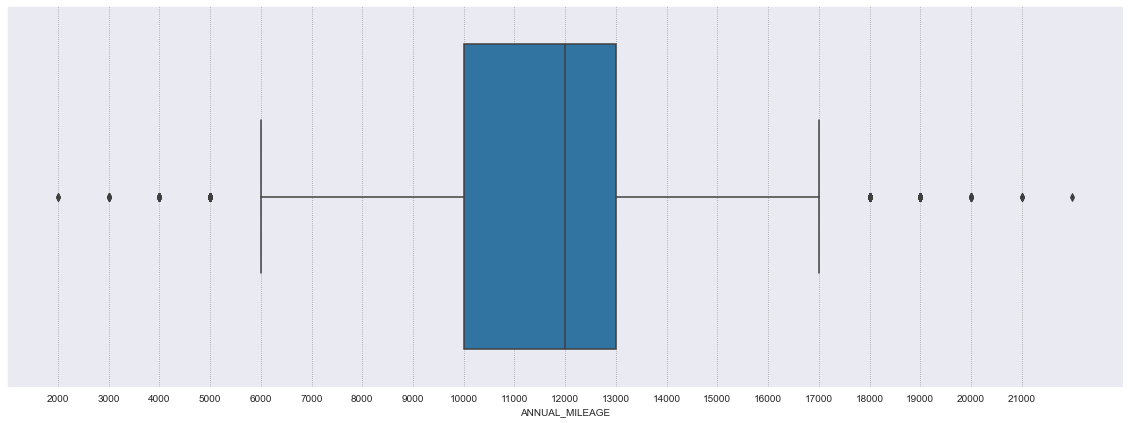

In [39]:
plt.figure(figsize=(20,7))
sns.boxplot(x = df_train_encoded['ANNUAL_MILEAGE'])
plt.xticks(np.arange(2000, 22000, 1000))
plt.show()

В этом признаке тоже есть выбросы, очистим значения меньше 6000 и больше 17000:

In [40]:
df_train_encoded = df_train_encoded[df_train_encoded['ANNUAL_MILEAGE'] >= 6000]
df_train_encoded = df_train_encoded[df_train_encoded['ANNUAL_MILEAGE'] <= 17000]
len(df_train_encoded)

7733

In [41]:
y_train_series = y_train_series[df_train_encoded.index]
len(y_train_series)

7733

# Построение RandomForest на обработанных данных

Данные дополнительно обработаны, теперь заново подбираем параметры и обучаем лучший алгоритм.

In [42]:
X_train = np.array(df_train_encoded)
y_train = np.array(y_train_series)

X_test = np.array(df_test_encoded)
y_test = np.array(y_test_series)

## Подбор параметров

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = [{
    'n_estimators' : [100, 200, 300],
    'min_samples_leaf' : [1, 3, 5, 7, 10],
    'max_features' : ['auto', 'sqrt', 'log2']
}]

model = RandomForestClassifier(class_weight='balanced')

gs = GridSearchCV(model, param_grid=param_grid, cv = 5, scoring='f1', verbose=3,  n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 3, 5, 7, 10],
                          'n_estimators': [100, 200, 300]}],
             scoring='f1', verbose=3)

In [46]:
gs.best_params_, gs.best_score_

({'max_features': 'auto', 'min_samples_leaf': 7, 'n_estimators': 200},
 0.7611991080233838)

## Тест

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [68]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced',
                             max_features='auto',min_samples_leaf=7)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))

0.7456896551724137


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1373
           1       0.68      0.83      0.75       627

    accuracy                           0.82      2000
   macro avg       0.80      0.82      0.80      2000
weighted avg       0.84      0.82      0.83      2000



В результате работы получилось улучшить скор , был  0.737527114967462, стал 0.7456896551724137, но разница не очень большая. Однако, в задачах машинного обучения важная каждая сотая качества классификации, поэтому таким путем мы добились лучших результатов. Возможно, был выбран не лучший алгоритм для решения данной задачи, однако, мне уж очень хотелось поработать со случайным лесом. Также не исключено, что проблема именно в данных и лучший скор тут получить довольно сложно.

Отличия скоров на кросс валидации и на тесте можно объяснить тем, что на кросс валидации в фолды попадают данные, на которых проводилась обработка признаков, а на тесте параметры обработки берутся исключительно из обучения.